In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('https://dl.dropboxusercontent.com/s/tlijezgr8tnpeym/ner_dataset.csv?dl=0', 
                 header=0, 
                 encoding='latin')

In [3]:
df['Sentence #'].fillna(method='ffill', inplace=True)

In [4]:
df.sample(5)

,Sentence #,Word,POS,Tag
1044077,Sentence: 47751,the,DT,O
636405,Sentence: 29092,ushered,VBD,O
552969,Sentence: 25285,World,NNP,O
35273,Sentence: 1583,Tuesday,NNP,B-tim
737931,Sentence: 33738,find,VB,O


## EDA

In [5]:
df['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

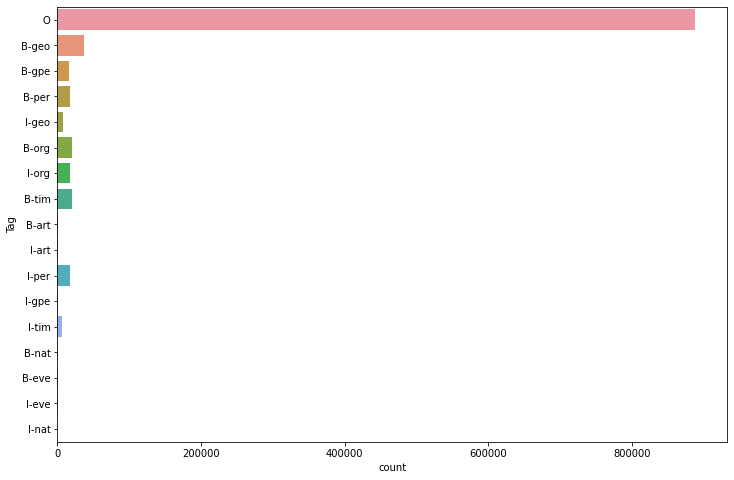

In [6]:
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Tag']);

In [7]:
num_sen = df['Sentence #'].nunique()
print(f'Number of sentences = {num_sen}')

Number of sentences = 47959


In [8]:
mean_words = df['Sentence #'].value_counts().mean()
min_words = df['Sentence #'].value_counts().min()
max_words = df['Sentence #'].value_counts().max()
print('Mean number of tokems in sentence= {:.3f}'.format(mean_words))
print('Min number of tokems in sentence= {}'.format(min_words))
print('Max number of tokems in sentence= {}'.format(max_words))

Mean number of tokems in sentence= 21.864
Min number of tokems in sentence= 1
Max number of tokems in sentence= 104


In [9]:
from collections import Counter

cnt_words = Counter(df['Word'])

In [10]:
print('The size of voxcabulary = {}'.format(len(cnt_words)))

The size of voxcabulary = 35178


## Data Prep

In [11]:
grouped = df.groupby(by='Sentence #').agg(lambda x: list(x))

In [12]:
test_dataset = grouped.iloc[-5000:,[0,2]]

In [13]:
train_dataset = grouped.iloc[ :-5000, [0,2]]

In [14]:
vocab = np.unique(np.array([word for words in train_dataset['Word'].values for word in words])).tolist()

In [15]:
states = df['Tag'].unique().tolist()

In [16]:
len(states)

17

## HMM

In [17]:
train_hmm = [[(word, tag) for tag, word in zip(*element)] for element in zip(train_dataset['Word'], train_dataset['Tag'])]

In [18]:
test_hmm = test_dataset['Word'].values.tolist()

In [19]:
from HMM import HMMTagger

In [20]:
tagger = HMMTagger(states, vocab)

In [21]:
tagger.fit(train_hmm)

In [22]:
predict = tagger.predict(test_hmm)

In [23]:
y_true = [tag for tags in test_dataset['Tag'] for tag in tags]

In [24]:
prediction = [tag for tags in predict for tag in tags]

In [25]:

print(classification_report(y_true, prediction))

/Users/avvallack/PycharmProjects/Advanced_NLP/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        44
       B-eve       0.00      0.00      0.00        44
       B-geo       0.83      0.85      0.84      3951
       B-gpe       0.89      0.88      0.88      1767
       B-nat       0.00      0.00      0.00        19
       B-org       0.77      0.59      0.67      2004
       B-per       0.77      0.71      0.74      1715
       B-tim       0.91      0.77      0.83      2077
       I-art       0.00      0.00      0.00        24
       I-eve       0.00      0.00      0.00        28
       I-geo       0.79      0.69      0.74       789
       I-gpe       0.80      0.27      0.40        15
       I-nat       0.00      0.00      0.00        10
       I-org       0.68      0.76      0.72      1628
       I-per       0.72      0.92      0.81      1732
       I-tim       0.82      0.46      0.59       646
           O       0.98      0.99      0.98     92190

    accuracy              

## CRF

In [26]:
from sklearn_crfsuite import CRF
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report

In [27]:
crf_corpus = [[(word, pos, tag) for word, pos, tag in zip(*element)] 
              for element in zip(grouped['Word'], grouped['POS'], grouped['Tag'])]

In [28]:
crf_corpus[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [29]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]


In [30]:
X = [sent2features(s) for s in crf_corpus]
y = [sent2labels(s) for s in crf_corpus]

In [31]:
crf = CRF(algorithm='lbfgs',
c1=10,
c2=0.1,
max_iterations=100,
all_possible_transitions=False)

In [32]:
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

/Users/avvallack/PycharmProjects/Advanced_NLP/venv/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [33]:
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

/Users/avvallack/PycharmProjects/Advanced_NLP/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       402
       B-eve       0.80      0.27      0.40       308
       B-geo       0.82      0.90      0.86     37644
       B-gpe       0.95      0.92      0.94     15870
       B-nat       0.69      0.09      0.16       201
       B-org       0.78      0.67      0.72     20143
       B-per       0.80      0.76      0.78     16990
       B-tim       0.93      0.83      0.88     20333
       I-art       0.00      0.00      0.00       297
       I-eve       0.64      0.12      0.20       253
       I-geo       0.81      0.73      0.77      7414
       I-gpe       0.93      0.37      0.53       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.75      0.76      0.75     16784
       I-per       0.80      0.90      0.85     17251
       I-tim       0.84      0.67      0.74      6528
           O       0.99      0.99      0.99    887908

    accuracy              

## Bi-Directional LSTM

In [41]:
import torch
from BiDirectionalLSTM import NerDataSet, NerNN, BiLSTM, padded_data_loader

### Data Prep

In [36]:
sentences = grouped['Word'].values
tags = grouped['Tag'].values

In [37]:
ds = NerDataSet(sentences, tags)

In [38]:
len(ds)

47959

In [39]:
learning_rate = 0.01
num_epochs = 2
device = 'cpu'
labels = list(range(1,18))
workers = 8

In [42]:
from torch.utils.data import random_split
train_set, test_set = random_split(ds, [40000, 7959], generator=torch.Generator().manual_seed(42))

In [43]:
train_loader = padded_data_loader(data=train_set, workers=workers, batch_size=32)

In [44]:
test_loader = padded_data_loader(data=test_set, workers=workers, batch_size=32)

### Model Training & Evaluation

In [45]:
model = BiLSTM(len(ds.vocab), len(ds.tag_vocab))

In [46]:
import torch.nn.functional as F
import torch 

In [47]:
from sklearn.metrics import confusion_matrix, f1_score

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
conf_matrix = np.zeros((len(ds.tag_vocab)-1, len(ds.tag_vocab)-1))
total_step = len(train_loader)
scores = []
for epoch in range(num_epochs):
    for i, (sentences, tags) in enumerate(train_loader):
        sentences = sentences.to(device)
        tags = tags.to(device)
        
        # Forward pass
        outputs = model(sentences)
        loss = F.cross_entropy(torch.flatten(outputs, 0, 1), torch.flatten(tags, 0, 1), ignore_index=0)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    model.eval()
    with torch.no_grad():
        for  sentences, tags in test_loader:
            sentences = sentences.to(device)
            tags = tags.to(device)
            tags = tags.flatten()
            tag_mask = tags != 0
            outputs = model(sentences)
            predicted = outputs.argmax(2)
            tags = tags[tag_mask]
            predicted = predicted.flatten()[tag_mask]
            conf_matrix += confusion_matrix(tags.numpy(), predicted.numpy(), labels=labels)
        tp = np.diagonal(conf_matrix)
        prec = tp / conf_matrix.sum(axis=0)
        rec = tp / conf_matrix.sum(axis=1)
        mask = np.logical_and(prec == 0, rec == 0)
        f1 = 2 * (prec * rec /(prec + rec))
        f1[mask] = 0
        print('Macro avg for f1 score on {} epoch = {:.3f}'.format(epoch, f1.mean()))
        scores.append(f1.mean())
    model.train()
            
            



Epoch [1/2], Step [100/1250], Loss: 0.2995
Epoch [1/2], Step [200/1250], Loss: 0.2059
Epoch [1/2], Step [300/1250], Loss: 0.1824
Epoch [1/2], Step [400/1250], Loss: 0.1258
Epoch [1/2], Step [500/1250], Loss: 0.1383
Epoch [1/2], Step [600/1250], Loss: 0.1387
Epoch [1/2], Step [700/1250], Loss: 0.1517
Epoch [1/2], Step [800/1250], Loss: 0.1742
Epoch [1/2], Step [900/1250], Loss: 0.1553
Epoch [1/2], Step [1000/1250], Loss: 0.2491
Epoch [1/2], Step [1100/1250], Loss: 0.1471
Epoch [1/2], Step [1200/1250], Loss: 0.0988
Macro avg for f1 score on 0 epoch = nan


<ipython-input-48-914e101ab54f>:35: RuntimeWarning: invalid value encountered in true_divide
  prec = tp / conf_matrix.sum(axis=0)


Epoch [2/2], Step [100/1250], Loss: 0.1271
Epoch [2/2], Step [200/1250], Loss: 0.1205
Epoch [2/2], Step [300/1250], Loss: 0.0944
Epoch [2/2], Step [400/1250], Loss: 0.0843
Epoch [2/2], Step [500/1250], Loss: 0.1117
Epoch [2/2], Step [600/1250], Loss: 0.0946
Epoch [2/2], Step [700/1250], Loss: 0.0828
Epoch [2/2], Step [800/1250], Loss: 0.1000
Epoch [2/2], Step [900/1250], Loss: 0.1093
Epoch [2/2], Step [1000/1250], Loss: 0.1915
Epoch [2/2], Step [1100/1250], Loss: 0.1000
Epoch [2/2], Step [1200/1250], Loss: 0.0758
Macro avg for f1 score on 1 epoch = nan


## Lightning model

In [49]:
import pytorch_lightning as pl


model = NerNN(len(ds.vocab), len(ds.tag_vocab))
logger = pl.loggers.TensorBoardLogger('tb_logs', name='ner_lstm_logs')

In [50]:
trainer = pl.Trainer(max_epochs=20, min_epochs=5 , logger=logger)
trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/Users/avvallack/PycharmProjects/Advanced_NLP/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.1 M 
1 | lstm      | LSTM      | 790 K 
2 | linear    | Linear    | 9.2 K 
----------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params


1

In [51]:
%load_ext tensorboard
%tensorboard --logdir NER/tb_logs

Reusing TensorBoard on port 6006 (pid 32368), started 12:30:05 ago. (Use '!kill 32368' to kill it.)

In [52]:
from sklearn.metrics import confusion_matrix

In [53]:
model.eval()
conf_matrix = np.zeros((len(ds.tag_vocab)-1, len(ds.tag_vocab)-1))
for  sentences, tags in test_loader:
    tags = tags.flatten()
    tag_mask = tags != 0
    outputs = model(sentences)
    predicted = outputs.argmax(2)
    tags = tags[tag_mask]
    predicted = predicted.flatten()[tag_mask]
    conf_matrix += confusion_matrix(tags.numpy(), predicted.numpy(), labels=labels)
tp = np.diagonal(conf_matrix)
prec = tp / conf_matrix.sum(axis=0)
rec = tp / conf_matrix.sum(axis=1)
mask = np.logical_and(prec == 0, rec == 0)
f1 = 2 * (prec * rec /(prec + rec))
f1[mask] = 0

<ipython-input-53-37cadd648b56>:15: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (prec * rec /(prec + rec))


In [54]:
labels = list(ds.tag_vocab.keys())[1:]
report = pd.DataFrame.from_dict({'labels': labels, 'recall': rec, 'precision': prec, 'f1': f1})
report.set_index('labels')

,recall,precision,f1
labels,,,
I-gpe,0.633333,0.678571,0.655172
I-org,0.638298,0.703498,0.669314
I-tim,0.724806,0.844244,0.779979
I-art,0.000000,0.000000,0.000000
I-eve,0.200000,0.230769,0.214286
B-gpe,0.931528,0.927581,0.929550
B-geo,0.844909,0.844498,0.844703
B-per,0.771459,0.793605,0.782375
I-per,0.832267,0.830791,0.831528


In [55]:
f1.mean(), rec.mean(), prec.mean()

(0.5960502707103876, 0.5756738098769476, 0.630836385536828)